In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from glob import glob
#from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import skimage.io
import warnings
import sys
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

In [2]:
# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = True

# seed_everything(SEED)

In [3]:
data_path='../input/prostate-cancer-grade-assessment/'

In [4]:
df=pd.read_csv(data_path+'train.csv')

In [5]:
df[df['data_provider']=='radboud']['image_id'].values

array(['0018ae58b01bdadc8e347995b69f99aa',
       '004dd32d9cd167d9cc31c13b704498af',
       '0068d4c7529e34fd4c9da863ce01a161', ...,
       'ffe06afd66a93258f8fabdef6044e181',
       'ffe236a25d4cbed59438220799920749',
       'ffe9bcababc858e04840669e788065a1'], dtype=object)

In [6]:
def crop_white(image: np.ndarray, mask: np.ndarray, value: int = 255) -> np.ndarray:
    assert image.shape[2] == 3
    assert image.dtype == np.uint8
    ys, = (image.min((1, 2)) < value).nonzero()
    xs, = (image.min((0, 2)) < value).nonzero()
    
    # if there's no pixel with such a value
    if len(xs) == 0 or len(ys) == 0:
        return image
    
    return image[ys.min():ys.max() + 1, xs.min():xs.max() + 1],mask[ys.min():ys.max() + 1, xs.min():xs.max() + 1]

In [7]:
def crop_images(img,mask,img_size=256,max_background_rate=0.8):
#     img=img[0]
#     mask=mask[0][:,:,0]
    img=img[1]
    mask=mask[1][:,:,0]
    
    img,mask=crop_white(img,mask)

    crop_img=[]
    crop_mask=[]

    def padding_mask(mask_tmp):
        pad=img_size-mask_tmp.shape[0]
        pad=np.full((pad,mask_tmp.shape[1]),0)
        mask_tmp=np.concatenate([mask_tmp,pad],axis=0)
        pad=img_size-mask_tmp.shape[1]
        pad=np.full((mask_tmp.shape[0],pad),0)
        mask_tmp=np.concatenate([mask_tmp,pad],axis=1)
        return mask_tmp


    def padding_img(img_tmp):
        pad=img_size-img_tmp.shape[0]
        pad=np.full((pad,img_tmp.shape[1],img_tmp.shape[2]),255)
        img_tmp=np.concatenate([img_tmp,pad],axis=0)
        pad=img_size-img_tmp.shape[1]
        pad=np.full((img_tmp.shape[0],pad,img_tmp.shape[2]),255)
        img_tmp=np.concatenate([img_tmp,pad],axis=1)
        return img_tmp
    

    tissue_cnt=5
    mask_cnt=1
    for i in range(img.shape[0]//img_size+1):
        for j in range(img.shape[1]//img_size+1):
            mask_tmp=mask[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size]            
            if mask_tmp.shape[0]<img_size or mask_tmp.shape[1]<img_size:
                mask_tmp=padding_mask(mask_tmp)

            img_tmp=img[i*img_size:(i+1)*img_size,j*img_size:(j+1)*img_size,:]
            if img_tmp.shape[0]<img_size or img_tmp.shape[1]<img_size:
                img_tmp=padding_img(img_tmp)
                
                
            if np.count_nonzero(mask_tmp==0)<img_size*img_size*max_background_rate:
                crop_img.append(img_tmp)
                crop_mask.append(mask_tmp)
                tissue_cnt+=1
            elif np.unique(mask_tmp)[-1]==0 and np.count_nonzero(img_tmp<255) and tissue_cnt/mask_cnt>5:
                crop_img.append(img_tmp)
                crop_mask.append(mask_tmp)
                mask_cnt+=1
    return crop_img,crop_mask
            


In [8]:
for name in tqdm(df[df['data_provider']=='radboud']['image_id'].values):

    img=skimage.io.MultiImage(data_path+'train_images/'+name+'.tiff')
    mask=skimage.io.MultiImage(data_path+'train_label_masks/'+name+'_mask.tiff')
    try:
        img_list,mask_list=crop_images(img,mask)
    except:
#         print(name,sys.exc_info())
        pass
    
    for idx, (img, mask) in enumerate(zip(img_list,mask_list)):
        img=Image.fromarray(img.astype('uint8'))
#         img=img.resize((512,512))
        img.save('../cropped_img/train_256_mod/'+name+'_'+str(idx)+'.png')
        mask=Image.fromarray(mask.astype('uint8'))
#         mask=mask.resize((512,512))
        mask.save('../cropped_img/mask_256_mod/'+name+'_'+str(idx)+'.png')
    

100%|██████████| 5160/5160 [1:19:41<00:00,  1.08it/s]


In [9]:
for i in range(len(img_list)//5):
    tmp=img_list[i*5]
    for j in range(1,5):
        tmp=np.concatenate([tmp,img_list[i*5+j]],axis=0)
    
    try:
        res=np.concatenate([res,tmp],axis=1)
    except:
        res=tmp
        
    tmp=mask_list[i*5]
    for j in range(1,5):
        tmp=np.concatenate([tmp,mask_list[i*5+j]],axis=0)
    try:
        mask_res=np.concatenate([mask_res,tmp],axis=1)
    except:
        mask_res=tmp
        
    

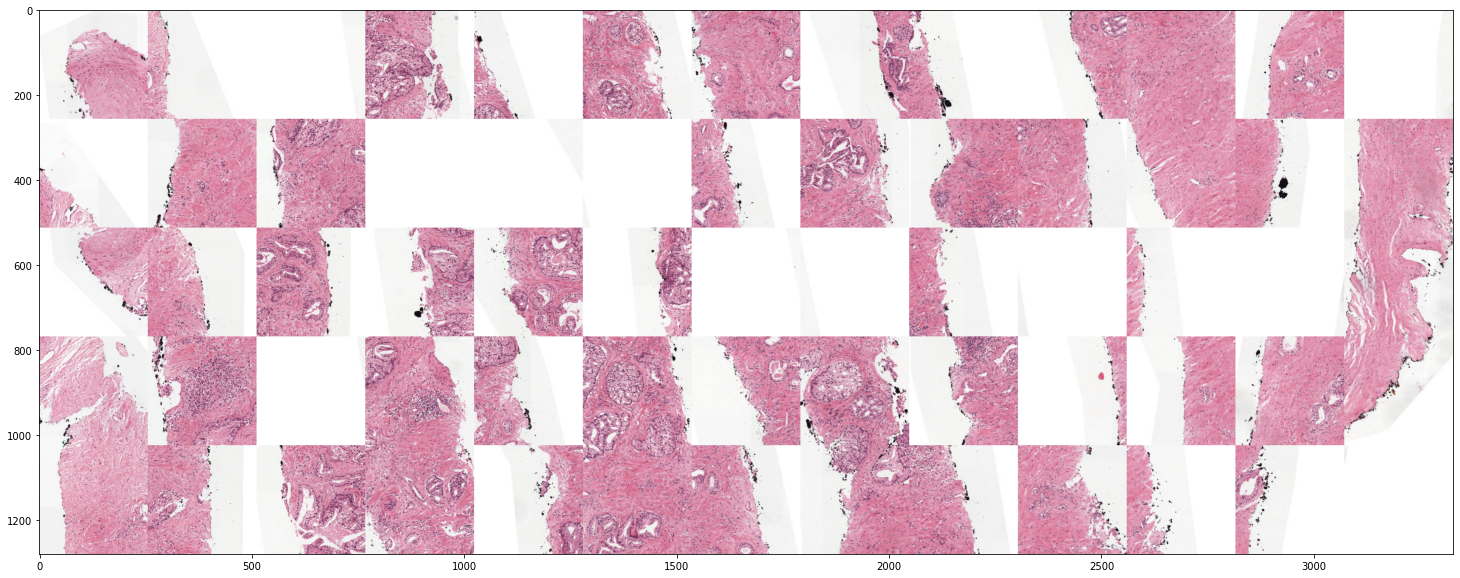

In [10]:
plt.figure(figsize=(30,10))
plt.imshow(res)

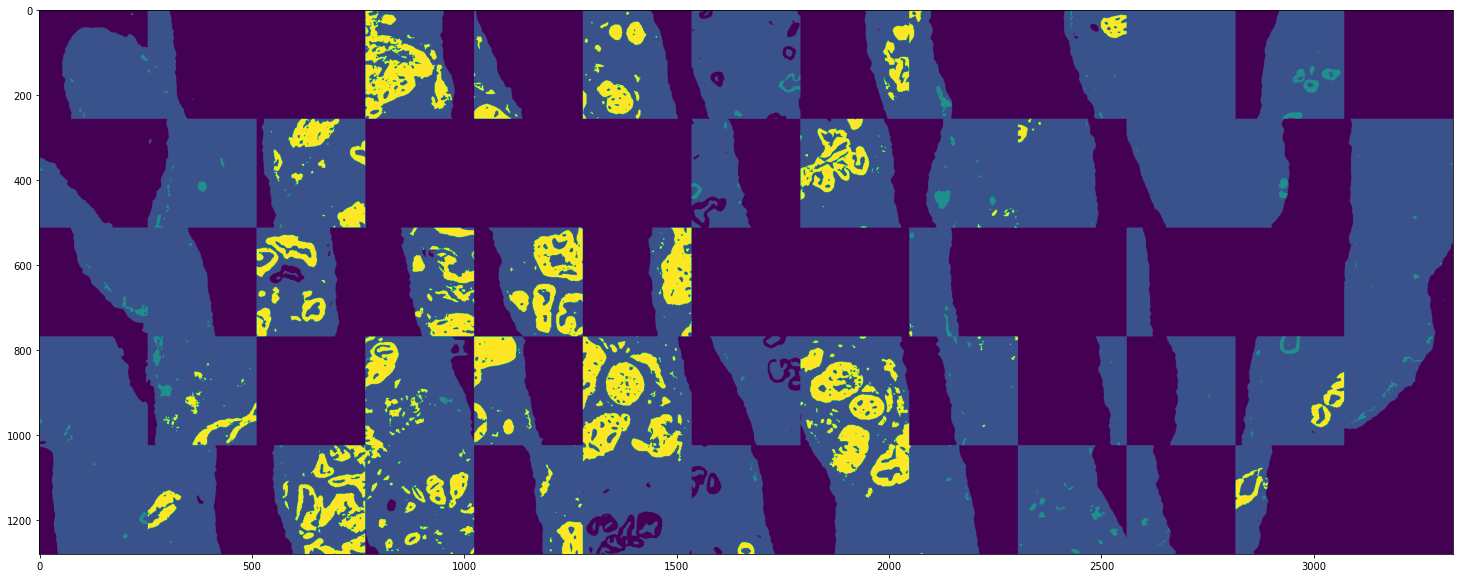

In [11]:
plt.figure(figsize=(30,10))
plt.imshow(mask_res)